# CatBoost

In [10]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn.over_sampling as oversampling
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import evaluate_metrics_2, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared_2.parquet")
df.head()

,family_history_diabetes,hypertension_history,cardiovascular_history,waist_to_hip_ratio,glucose_fasting,glucose_postprandial,hba1c,diabetes_risk_score,glucose_fasting_times_hba1c,glucose_postprandial_times_hba1c,...,hdl_cholesterol_Normal,hdl_cholesterol_High,ldl_cholesterol_Near_optimal,ldl_cholesterol_Borderline_high,ldl_cholesterol_High,ldl_cholesterol_Very_high,triglycerides_Borderline_high,triglycerides_High,insulin_level_Normal,insulin_level_High
0,0,0,0,0.89,136,236,8.18,1,1112.479980,1930.480103,...,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0.80,93,150,5.63,1,523.590027,844.500000,...,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0.81,118,195,7.51,1,886.180054,1464.450073,...,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0.88,139,253,9.03,1,1255.169922,2284.589844,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0.78,137,184,7.20,1,986.399963,1324.799927,...,1,0,1,0,0,0,1,0,1,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["diabetes_risk_score"]),
    df["diabetes_risk_score"],
    test_size=0.2,
    random_state=2025
)

In [5]:
n_low = np.sum(y_train == 0)
n_medium = np.sum(y_train == 1)
n_high = np.sum(y_train == 2)

ratio = {0: round(n_low * 5), 1: n_medium, 2: round(n_high * 10)}

smt = oversampling.SMOTE(sampling_strategy=ratio, random_state=2025)

X_train_rs, y_train_rs = smt.fit_resample(X_train, y_train)

Let us try an untuned model first, once again.

In [6]:
cat_untuned = CatBoostClassifier(random_seed=2025, verbose=0)
cat_untuned.fit(X_train, y_train)

y_train_pred = cat_untuned.predict(X_train)
y_test_pred = cat_untuned.predict(X_test)

Training Set Metrics:


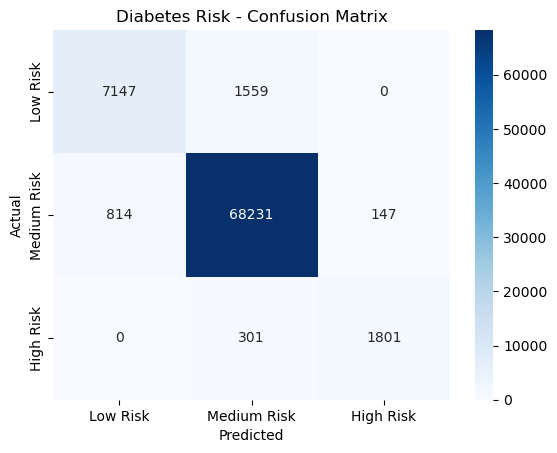

Accuracy:  0.9647
Precision: 0.9639
Recall:    0.9647
F1 Score:  0.9641


Test Set Metrics:


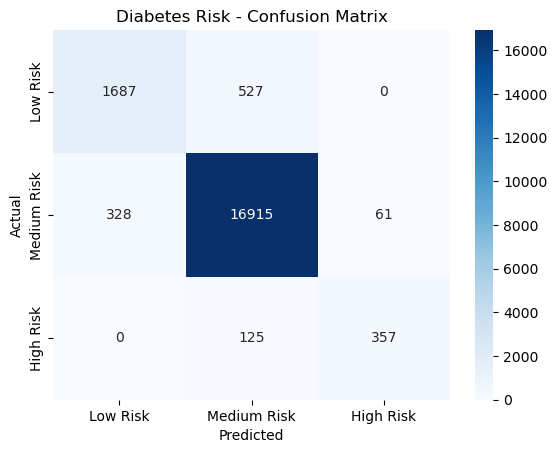

Accuracy:  0.9479
Precision: 0.9464
Recall:    0.9479
F1 Score:  0.9468


In [7]:
evaluate_metrics_2(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics_2(y_test, y_test_pred, "Test Set Metrics:")

That model performs well. Let us look at the feature importances.

In [9]:
feature_importances = cat_untuned.get_feature_importance(Pool(X_train, label=y_train))
feature_names = df.drop(columns=['diabetes_risk_score']).columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                      Feature  Importance
0                     family_history_diabetes   25.160198
12                                  age_60-69    7.204782
11                                  age_50-59    6.672655
38  physical_activity_minutes_per_week_Active    6.283322
13                                  age_70-79    5.243358
..                                        ...         ...
61                     cholesterol_total_High    0.045558
67                  ldl_cholesterol_Very_high    0.004279
70                       insulin_level_Normal    0.002085
71                         insulin_level_High    0.000728
59                     heart_rate_Tachycardia    0.000011

[72 rows x 2 columns]


C:\Users\Sebastijan\AppData\Local\Temp\ipykernel_14668\1604976173.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


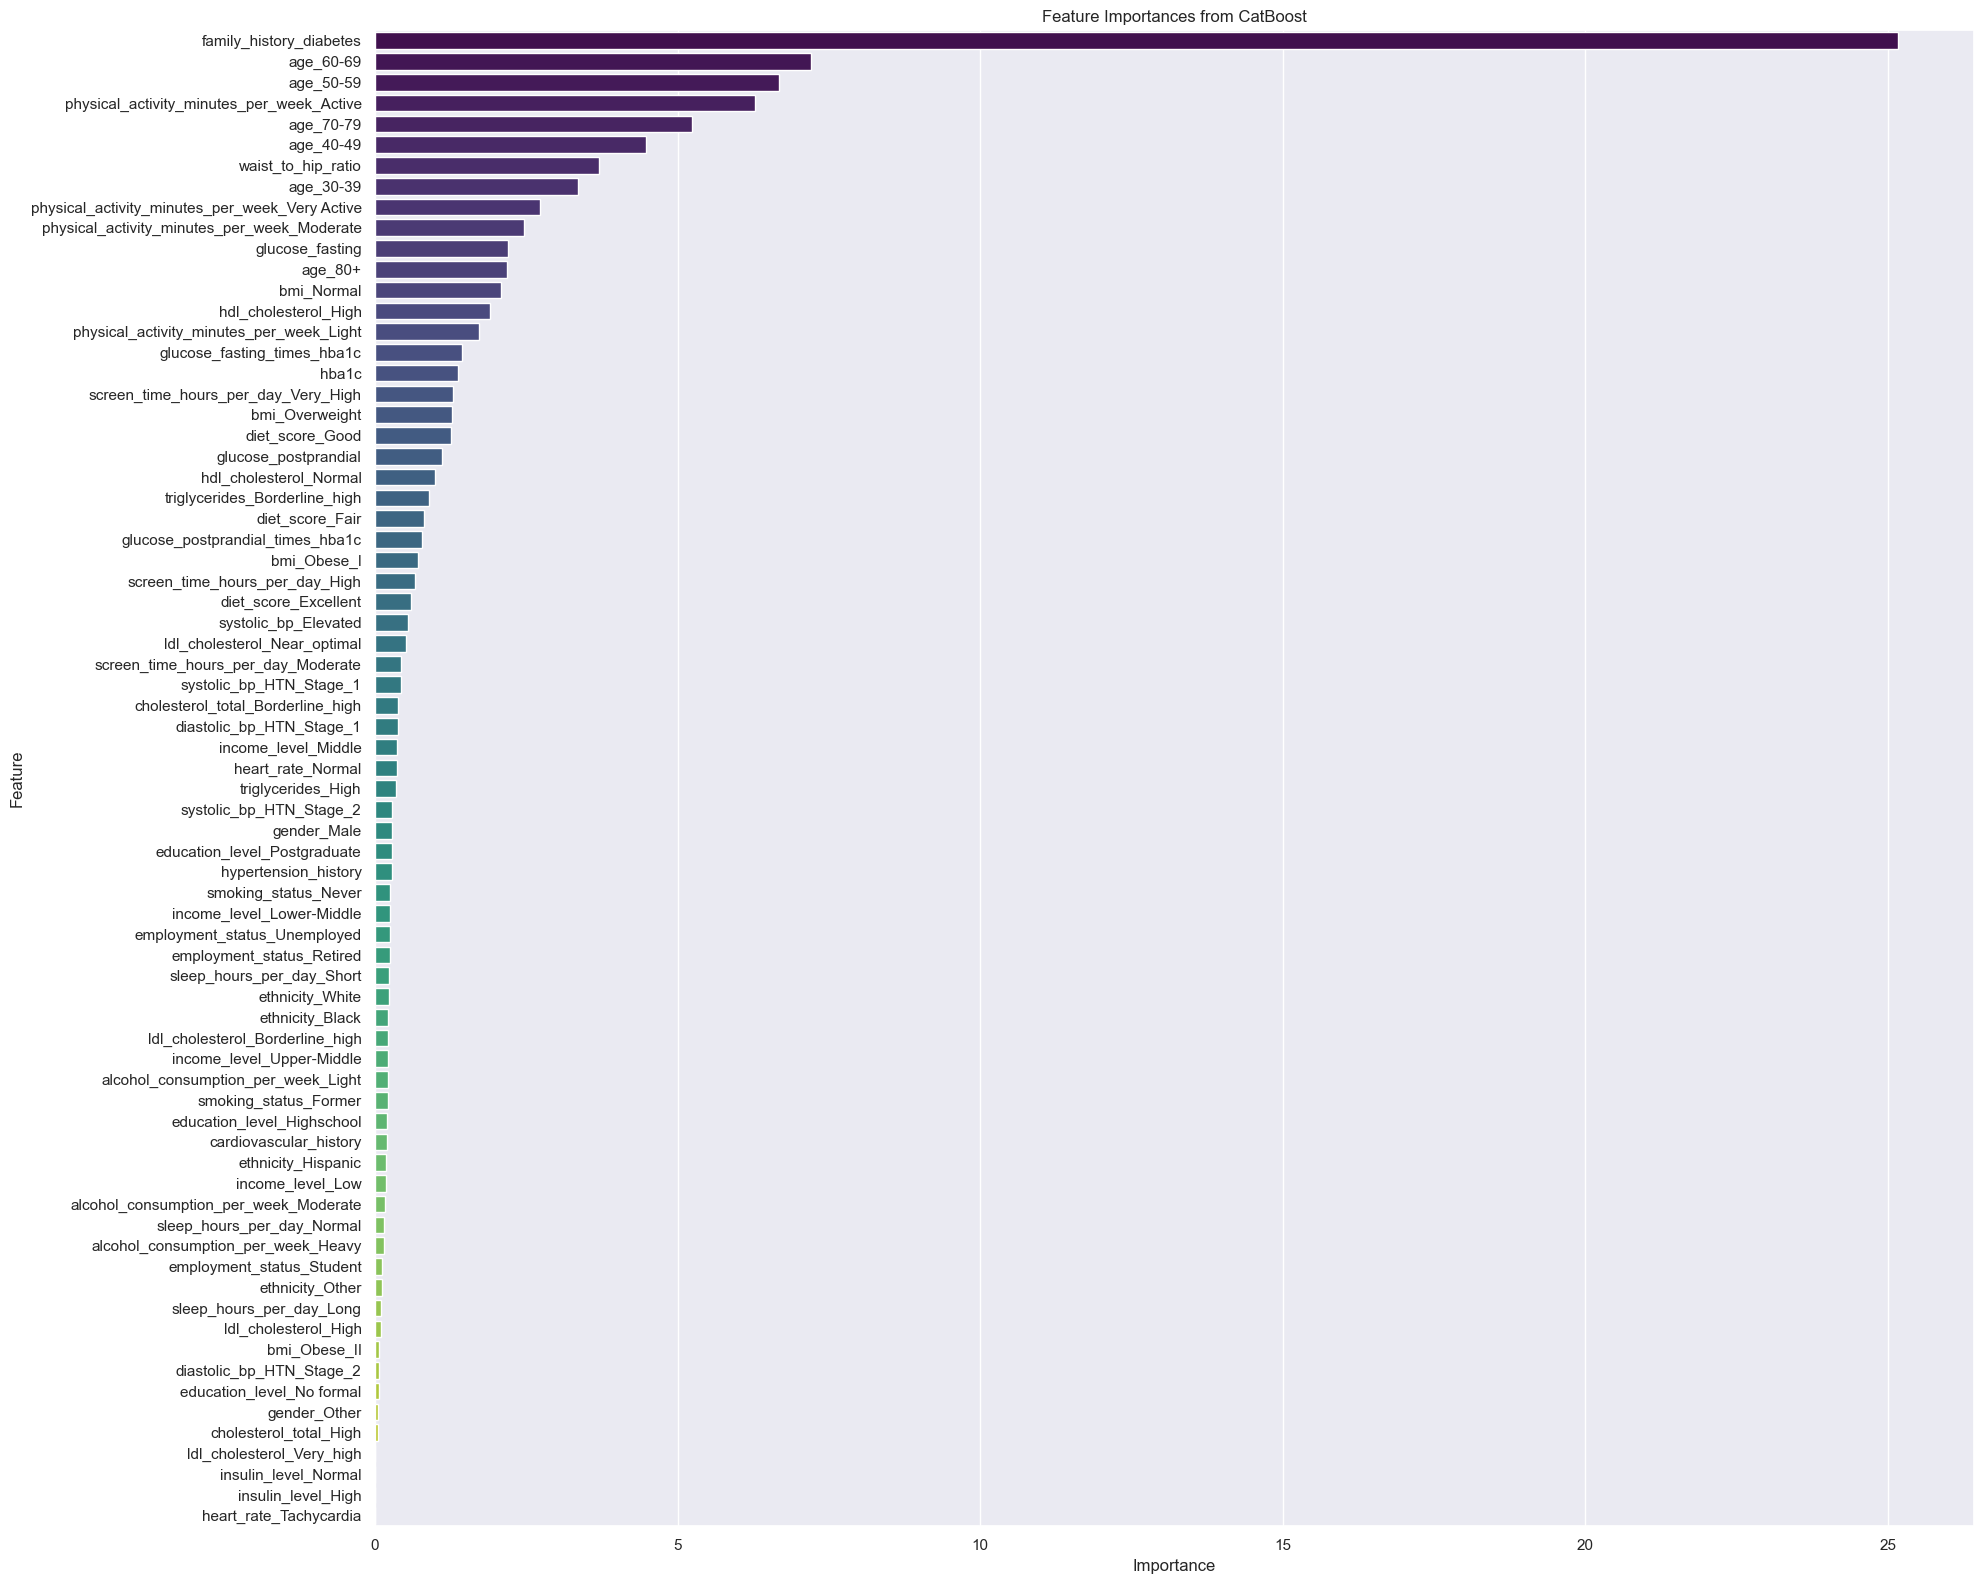

In [14]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(20, 16))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df, 
    palette='viridis'
)

plt.title('Feature Importances from CatBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


It looks like having a family history of diabetes is a major risk factor according to our model. Age and physical activity are also important. BMI and waist-to-hip ratio are also good indicators. Let's see what kind of performance we can get with different sets of limited features.

We will begin with having a family history of diabetes, age, physical activity, and waist-to-hip ratio.

In [15]:
chosen_columns = ["family_history_diabetes", "age_60-69", "age_50-59", "physical_activity_minutes_per_week_Active", "age_70-79", "age_40-49", "waist_to_hip_ratio", "age_30-39", "physical_activity_minutes_per_week_Very Active", "physical_activity_minutes_per_week_Moderate", "age_80+"]

In [16]:
cat_untuned_2 = CatBoostClassifier(random_seed=2025, verbose=0)
cat_untuned_2.fit(X_train[chosen_columns], y_train)

y_train_pred = cat_untuned_2.predict(X_train[chosen_columns])
y_test_pred = cat_untuned_2.predict(X_test[chosen_columns])

Training Set Metrics:


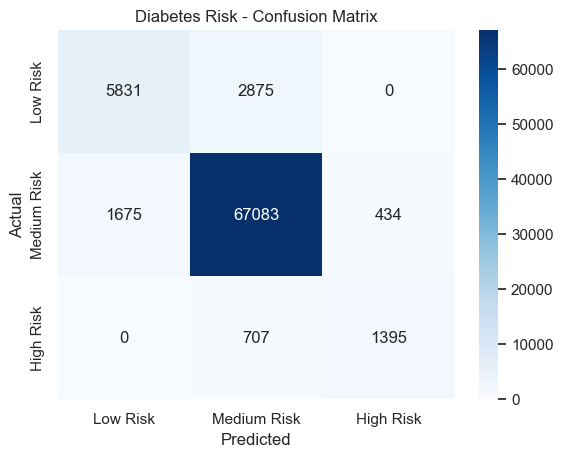

Accuracy:  0.9289
Precision: 0.9256
Recall:    0.9289
F1 Score:  0.9266


Test Set Metrics:


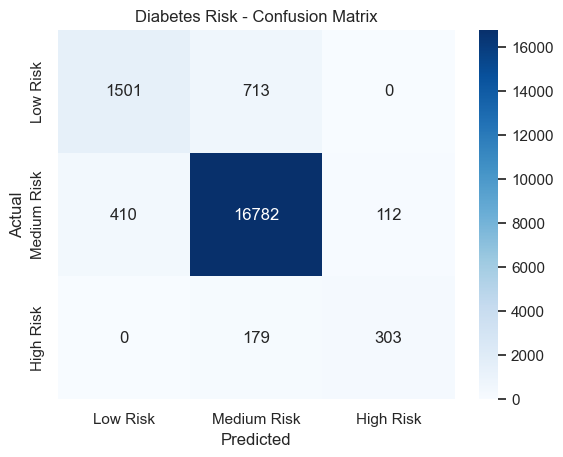

Accuracy:  0.9293
Precision: 0.9261
Recall:    0.9293
F1 Score:  0.9271


In [17]:
evaluate_metrics_2(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics_2(y_test, y_test_pred, "Test Set Metrics:")

This model does not perform much worse than the other one, and it even overfits less. Let's add bmi.

In [18]:
chosen_columns = ["family_history_diabetes", "age_60-69", "age_50-59", "physical_activity_minutes_per_week_Active", "age_70-79", "age_40-49", "waist_to_hip_ratio", "age_30-39", "physical_activity_minutes_per_week_Very Active", "physical_activity_minutes_per_week_Moderate", "age_80+", "bmi_Normal", "bmi_Overweight", "bmi_Obese_I", "bmi_Obese_II"]

In [19]:
cat_untuned_3 = CatBoostClassifier(random_seed=2025, verbose=0)
cat_untuned_3.fit(X_train[chosen_columns], y_train)

y_train_pred = cat_untuned_3.predict(X_train[chosen_columns])
y_test_pred = cat_untuned_3.predict(X_test[chosen_columns])

Training Set Metrics:


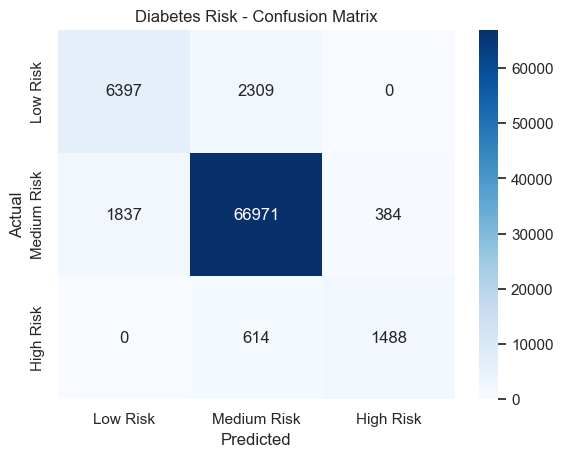

Accuracy:  0.9357
Precision: 0.9342
Recall:    0.9357
F1 Score:  0.9348


Test Set Metrics:


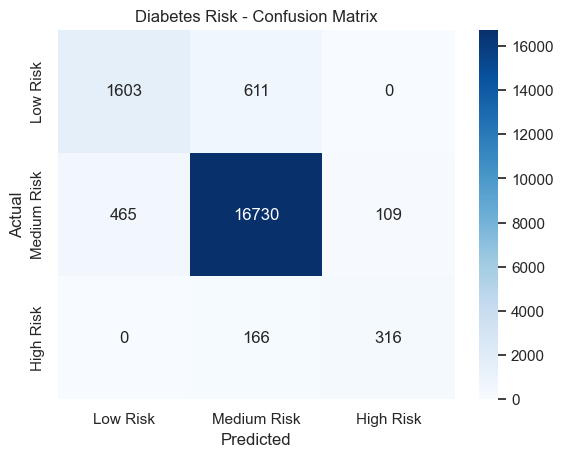

Accuracy:  0.9325
Precision: 0.9305
Recall:    0.9325
F1 Score:  0.9313


In [20]:
evaluate_metrics_2(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics_2(y_test, y_test_pred, "Test Set Metrics:")

This model performs reasonably close to the first one, which included all features. Given that adding more features would imply adding those that require a blood test, we will not be doing that. Instead, we will try to optimize the hyperparameters now.

In [26]:
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.2, 0.5, 0.8, 1],
    'iterations': [500, 1000, 1500]
}

cbc = CatBoostClassifier(loss_function="MultiClass", eval_metric='MultiClass', verbose=0)
random_search = RandomizedSearchCV(
    cbc, 
    param_distributions=param_dist,
    n_iter=25, 
    cv=3, 
    scoring='f1_macro', 
    n_jobs=-1
)
random_search.fit(X_train[chosen_columns], y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.2, 'l2_leaf_reg': 7, 'iterations': 500, 'depth': 6, 'bagging_temperature': 0.8}


In [27]:
cat_1 = CatBoostClassifier(**best_params, random_seed=2025, verbose=0)
cat_1.fit(X_train[chosen_columns], y_train)

y_train_pred = cat_1.predict(X_train[chosen_columns])
y_test_pred = cat_1.predict(X_test[chosen_columns])

Training Set Metrics:


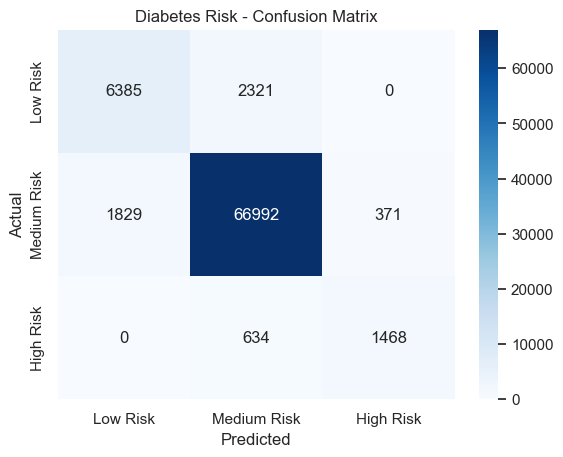

Accuracy:  0.9356
Precision: 0.9339
Recall:    0.9356
F1 Score:  0.9346


Test Set Metrics:


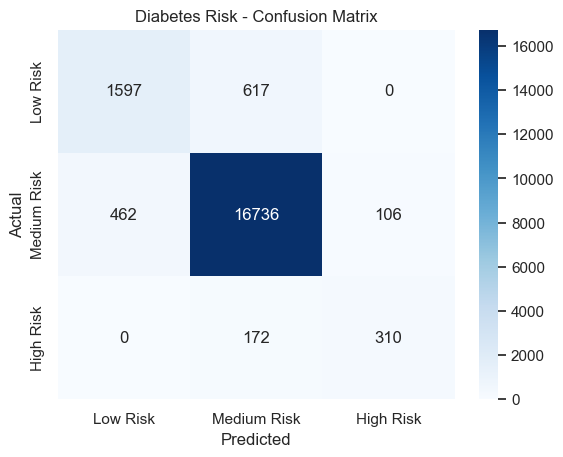

Accuracy:  0.9322
Precision: 0.9301
Recall:    0.9322
F1 Score:  0.9309


In [28]:
evaluate_metrics_2(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics_2(y_test, y_test_pred, "Test Set Metrics:")

This did not improve our model. We will stick to the cat_untuned_3 model and plot the roc curve.

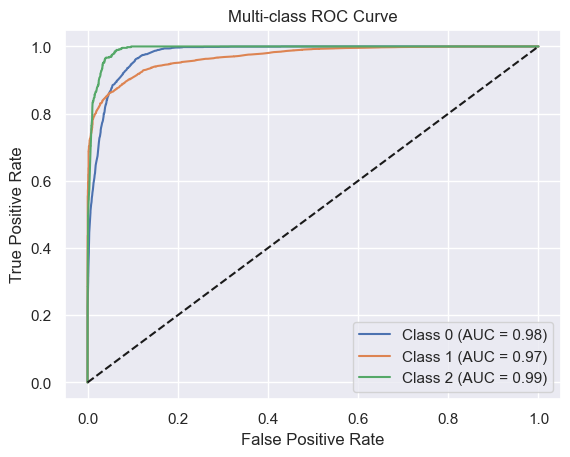

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1,2])
y_score = cat_untuned_3.predict_proba(X_test[chosen_columns])

plt.figure()
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend()
plt.show()

AUC looks very good! We will save this model.

In [36]:
joblib.dump(cat_untuned_3, '../models/cat_2.joblib')

['../models/cat_2.joblib']